# Analyzing a single damped sinusoid

This is the simplest possible example: we analyze a single damped sinusoid in white Gaussian noise. We use this case study to demonstrate some basic features of ringdown, including:

* how to measure generic frequencies and damping rates
* how to set up a fit and run it
* how to make some useful plots

Let's get started!

This first cell must be executed first in order for Stan's multiprocessing code to not crash some MacOS setups; on linux it's not needed.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *
import arviz as az
import seaborn as sns
import pandas as pd
import ringdown as rd

sns.set(context='notebook', palette='colorblind')

/home/ljq/miniconda3/envs/ringdown/lib/python3.11/site-packages/ringdown/data.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/ljq/miniconda3/envs/ringdown/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Let's create the simplest possible signal and add Gaussian noise to it. Although `rigndown` contains tools to create and maniuplate more complex ringdown and inspiral-merger-ringdown waveforms, we do not need that for this very simple example.

### Signal

First, create a time array based on a specified sampling rate and duration; center it around a target time $t_0$.

In [3]:
# define sampling rate and duration (make these powers of two) 
fsamp = 8192
duration = 4
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch

We can now use the above timestmps to create a simulated damped sinusoid starting at $t_0$; for good measure, let's extend the signal before $t_0$ to be a corresponding ring-up (the inference is insensitive to what happens before $t_0$, so we can always just let the signal vanish for $t < t_0$, as long as no step in the data conditioning involves taking a Fourier transform---which is true in the example here).

In [4]:
wf_kws = dict(
    A = 2,
    phi = 0,
    f = 250,
    gamma = 250,
)

def get_signal(time, A, phi, f, gamma):
    s = A*cos(2*np.pi*f*(time-t0) + phi)*exp(-gamma*abs(time-t0))
    return rd.Data(s, index=time)

signal = get_signal(time, **wf_kws)

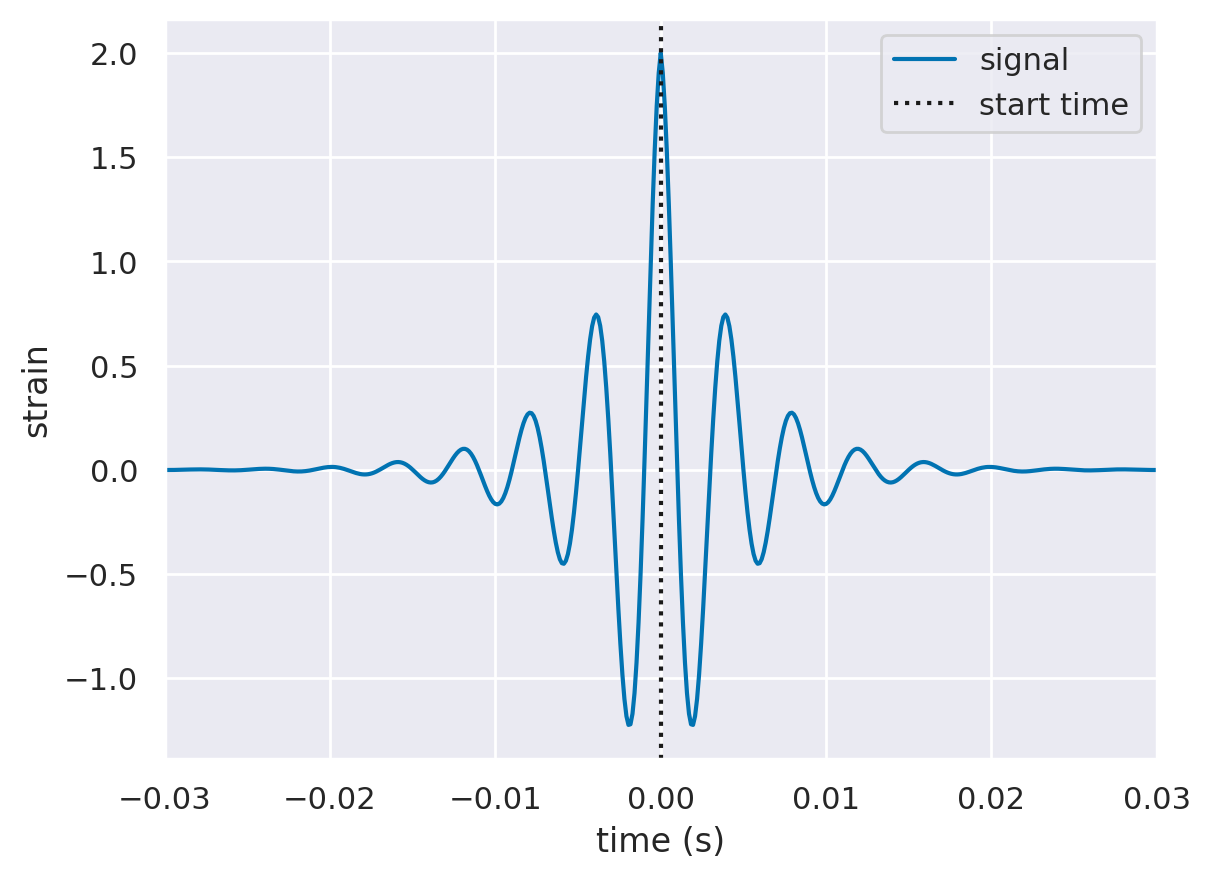

In [5]:
signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

### Noise

Let's add some white Gaussian noise to the signal to obtain our data. This means the autocorrelation function (ACF) of the noise will be $\rho(\tau) = \delta(\tau)$.

In [6]:
rng = np.random.default_rng(12345)
data = signal + rng.normal(0, 1, len(signal))

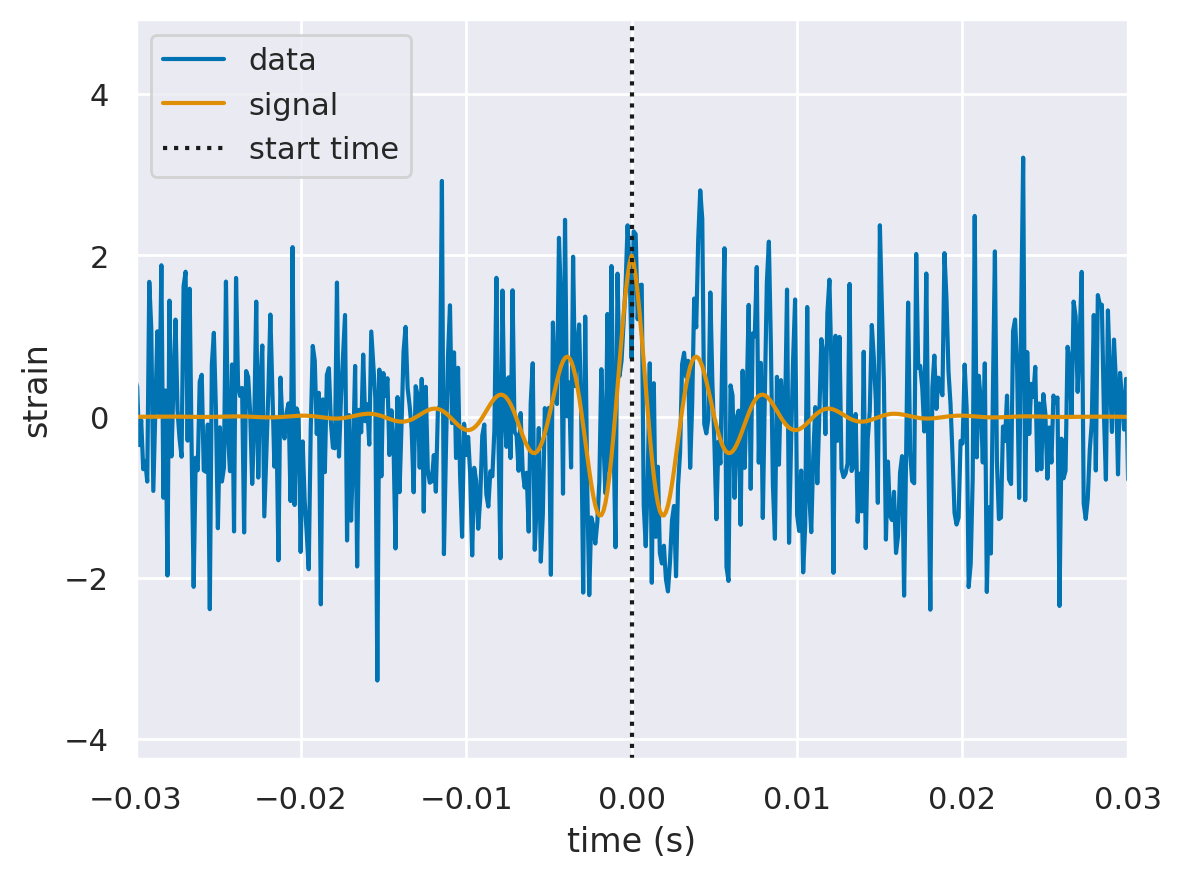

In [7]:
data.plot(label='data')
signal.plot(label='signal')
axvline(t0, ls=':', c='k', label='start time')
xlim(-0.03, 0.03)
xlabel('time (s)')
ylabel('strain')
legend();

For our ringdown analysis, we will need the ACFs corresponding to the noise, which we could estimate empirically from the data; in this case, however, we know the ACF to be a delta function at the origin (corresponding to standard Gaussian noise).

In [8]:
acf = rd.AutoCovariance(zeros_like(data), delta_t=data.delta_t)
acf.iloc[0] = 1

Of course, when working with white noise it is unnecessary to work with the ACF: all we have is a variance (in this case, $\sigma^2 = 1$) and the likelihood simplifies drastically. However, in real life we never have white noise, so `ringdown` expects an ACF and cannot currently accomodate a scalar variance.

## Fit

We are now ready to analyze the ringdown! Let's create a `Fit` object and set up the analysis. To do this, we first need to specify the model to be fit and the number (or kind) of modes to be used. In this case, we will be using the `ftau` model, which is parameterized in terms of damped sinusoids with generic frequencies $f_n$, damping rates $\gamma_n = 1/\tau_n$, amplitudes $A_n$, and phases $\phi_n$, defined such that successive modes are ordered in terms of damping rate ($\gamma_n < \gamma_{n+1}$); for this is example, we will only inject and recover a single mode.

In [9]:
fit = rd.Fit('ftau', modes=1)

TypeError: Fit.__init__() got multiple values for argument 'modes'

Since we already have the data and ACFs, we can add those directly to the fit now.

In [ ]:
fit.add_data(data, acf=acf, ifo='X')

Now, let's specify a target for the analysis, i.e., the desired start time and analysis segment duration.

<div class="alert alert-info">

Note

We will pick a very short duration to make this is example run fast, but in a real analysis this should be set based on the timescale imposed by the whitening filter and might well exceed the duration of the unwhitened signal.

</div>

In [ ]:
fit.set_target(t0, duration=0.03)

Finally, let's set some reasonable prior based on our knowledge of the true signal.

In [ ]:
fit.update_prior(A_scale=5, f_min=50, f_max=500, gamma_min=50, gamma_max=500)
fit.prior_settings

{'A_scale': 5, 'f_max': 500, 'f_min': 50, 'gamma_max': 500, 'gamma_min': 50}

Our fit is ready to go; run it!

<div class="alert alert-info">

Note

The `run()` method will automatically compile the `pymc` code the first time any fit runs in a given session, which can take a while.  Subsequent runs will use the precompiled code and be much quicker.

</div>

In [ ]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, gamma, Ax_unit, Ay_unit]
INFO:pymc:NUTS: [f, gamma, Ax_unit, Ay_unit]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


## Result

After the run is done, `fit.result` contains an [Arviz](https://arviz-devs.github.io/arviz/) object giving our results:

In [ ]:
az.summary(fit.result, var_names=['A', 'phi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],2.364,0.482,1.510,3.256,0.012,0.009,1636.0,1226.0,1.0
phi[0],-0.197,0.259,-0.677,0.264,0.007,0.005,1399.0,1337.0,1.0
f[0],240.574,13.978,216.428,265.561,0.345,0.245,1612.0,1394.0,1.0
tau[0],0.005,0.001,0.003,0.007,0.000,0.000,1446.0,1038.0,1.0


We can plot a trace, and see visually that the sampling seems OK for all the different chains (chains are represented by a different linestyle):

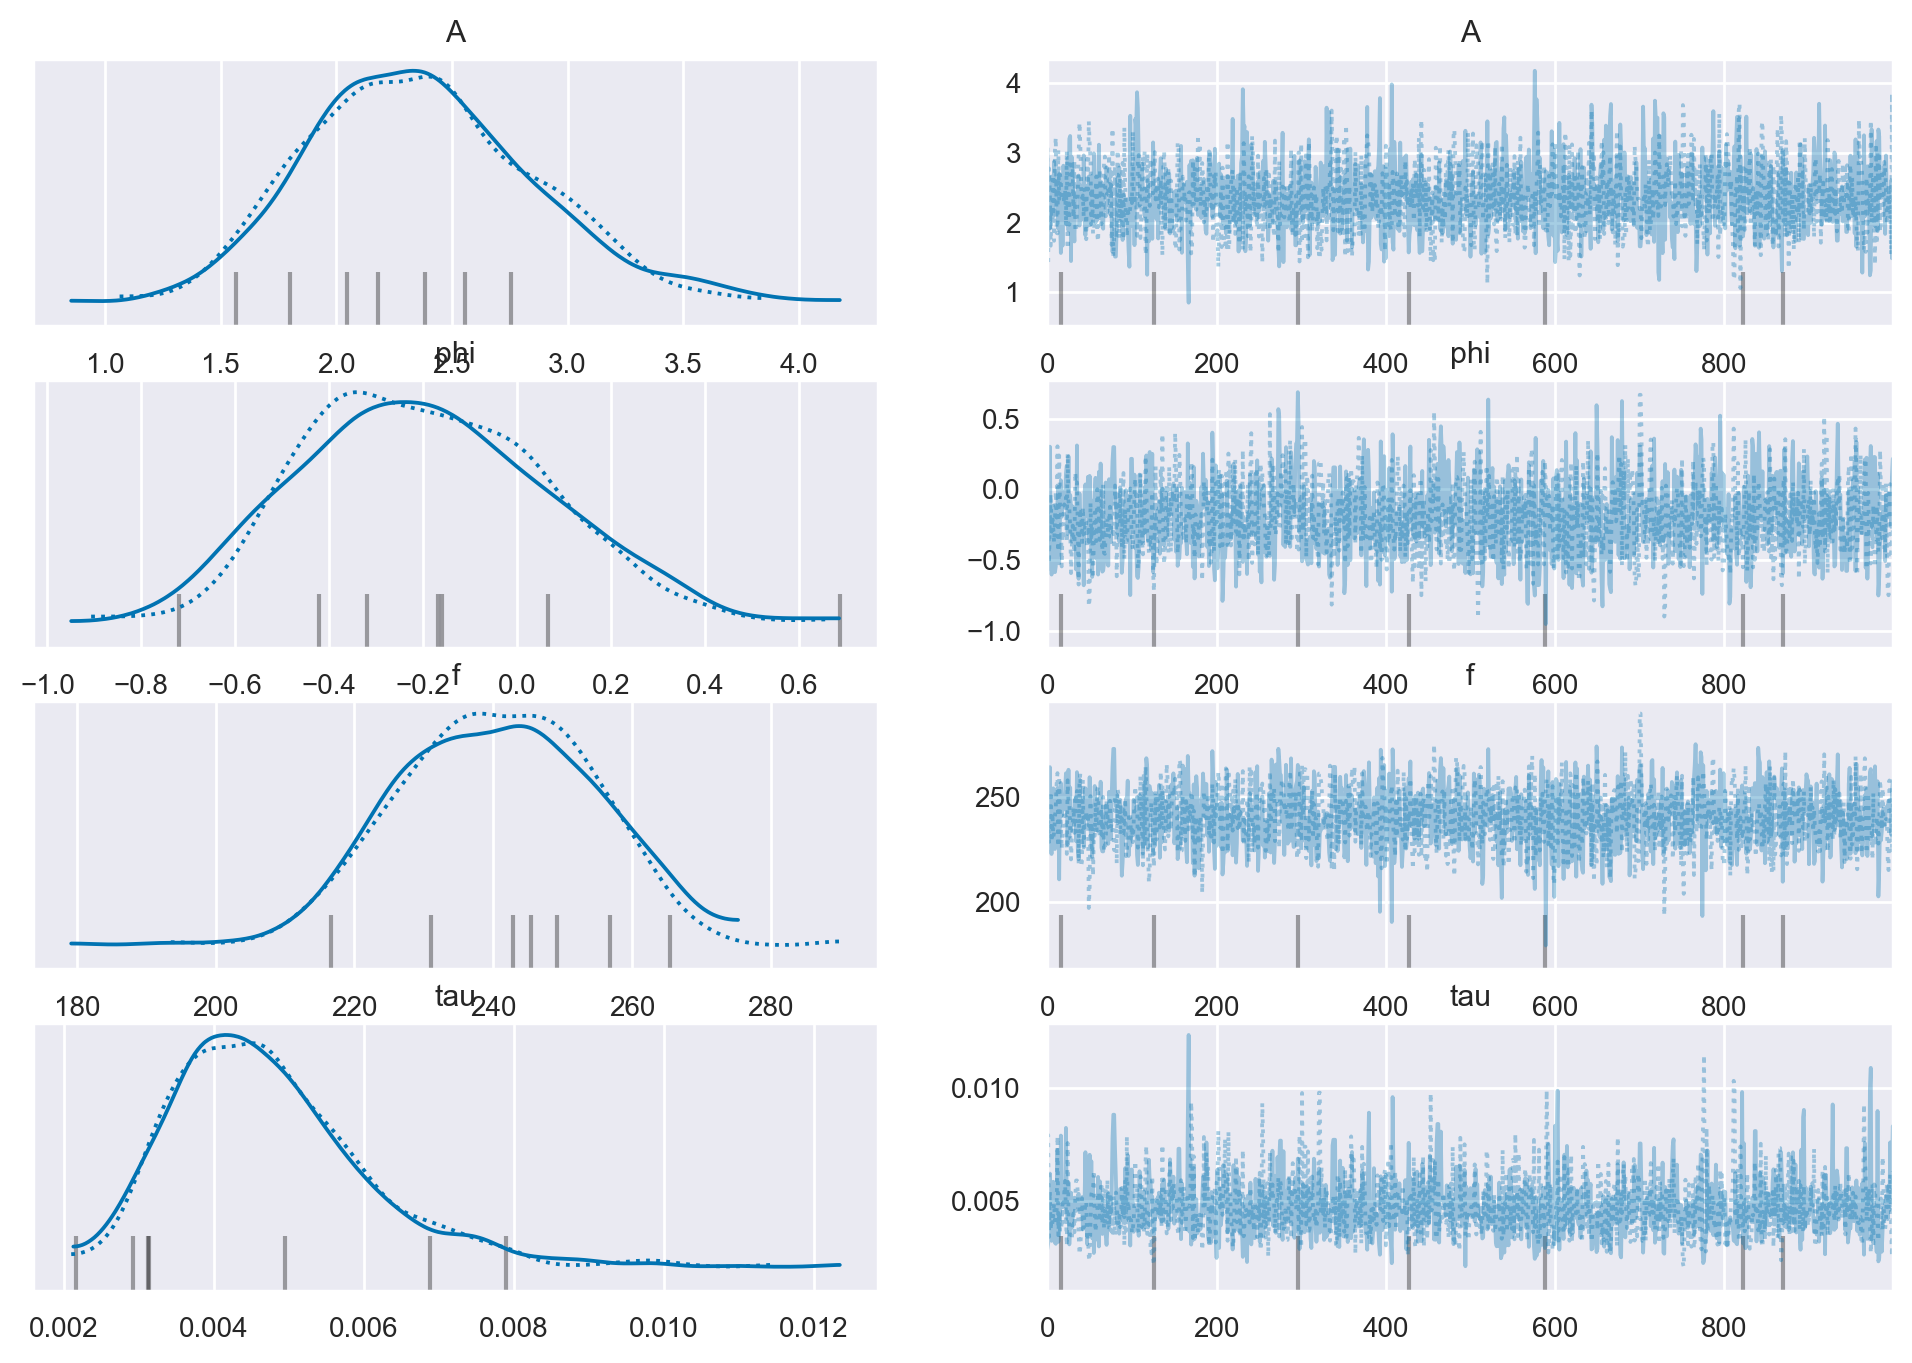

In [ ]:
az.plot_trace(fit.result, var_names=['A', 'phi', 'f', 'tau'], compact=True);

This is a very useful plot to diagnose the quality of a fit.

### Posterior

We can also make a corner plot using Seaborn, and check that the posterior supports the truth.

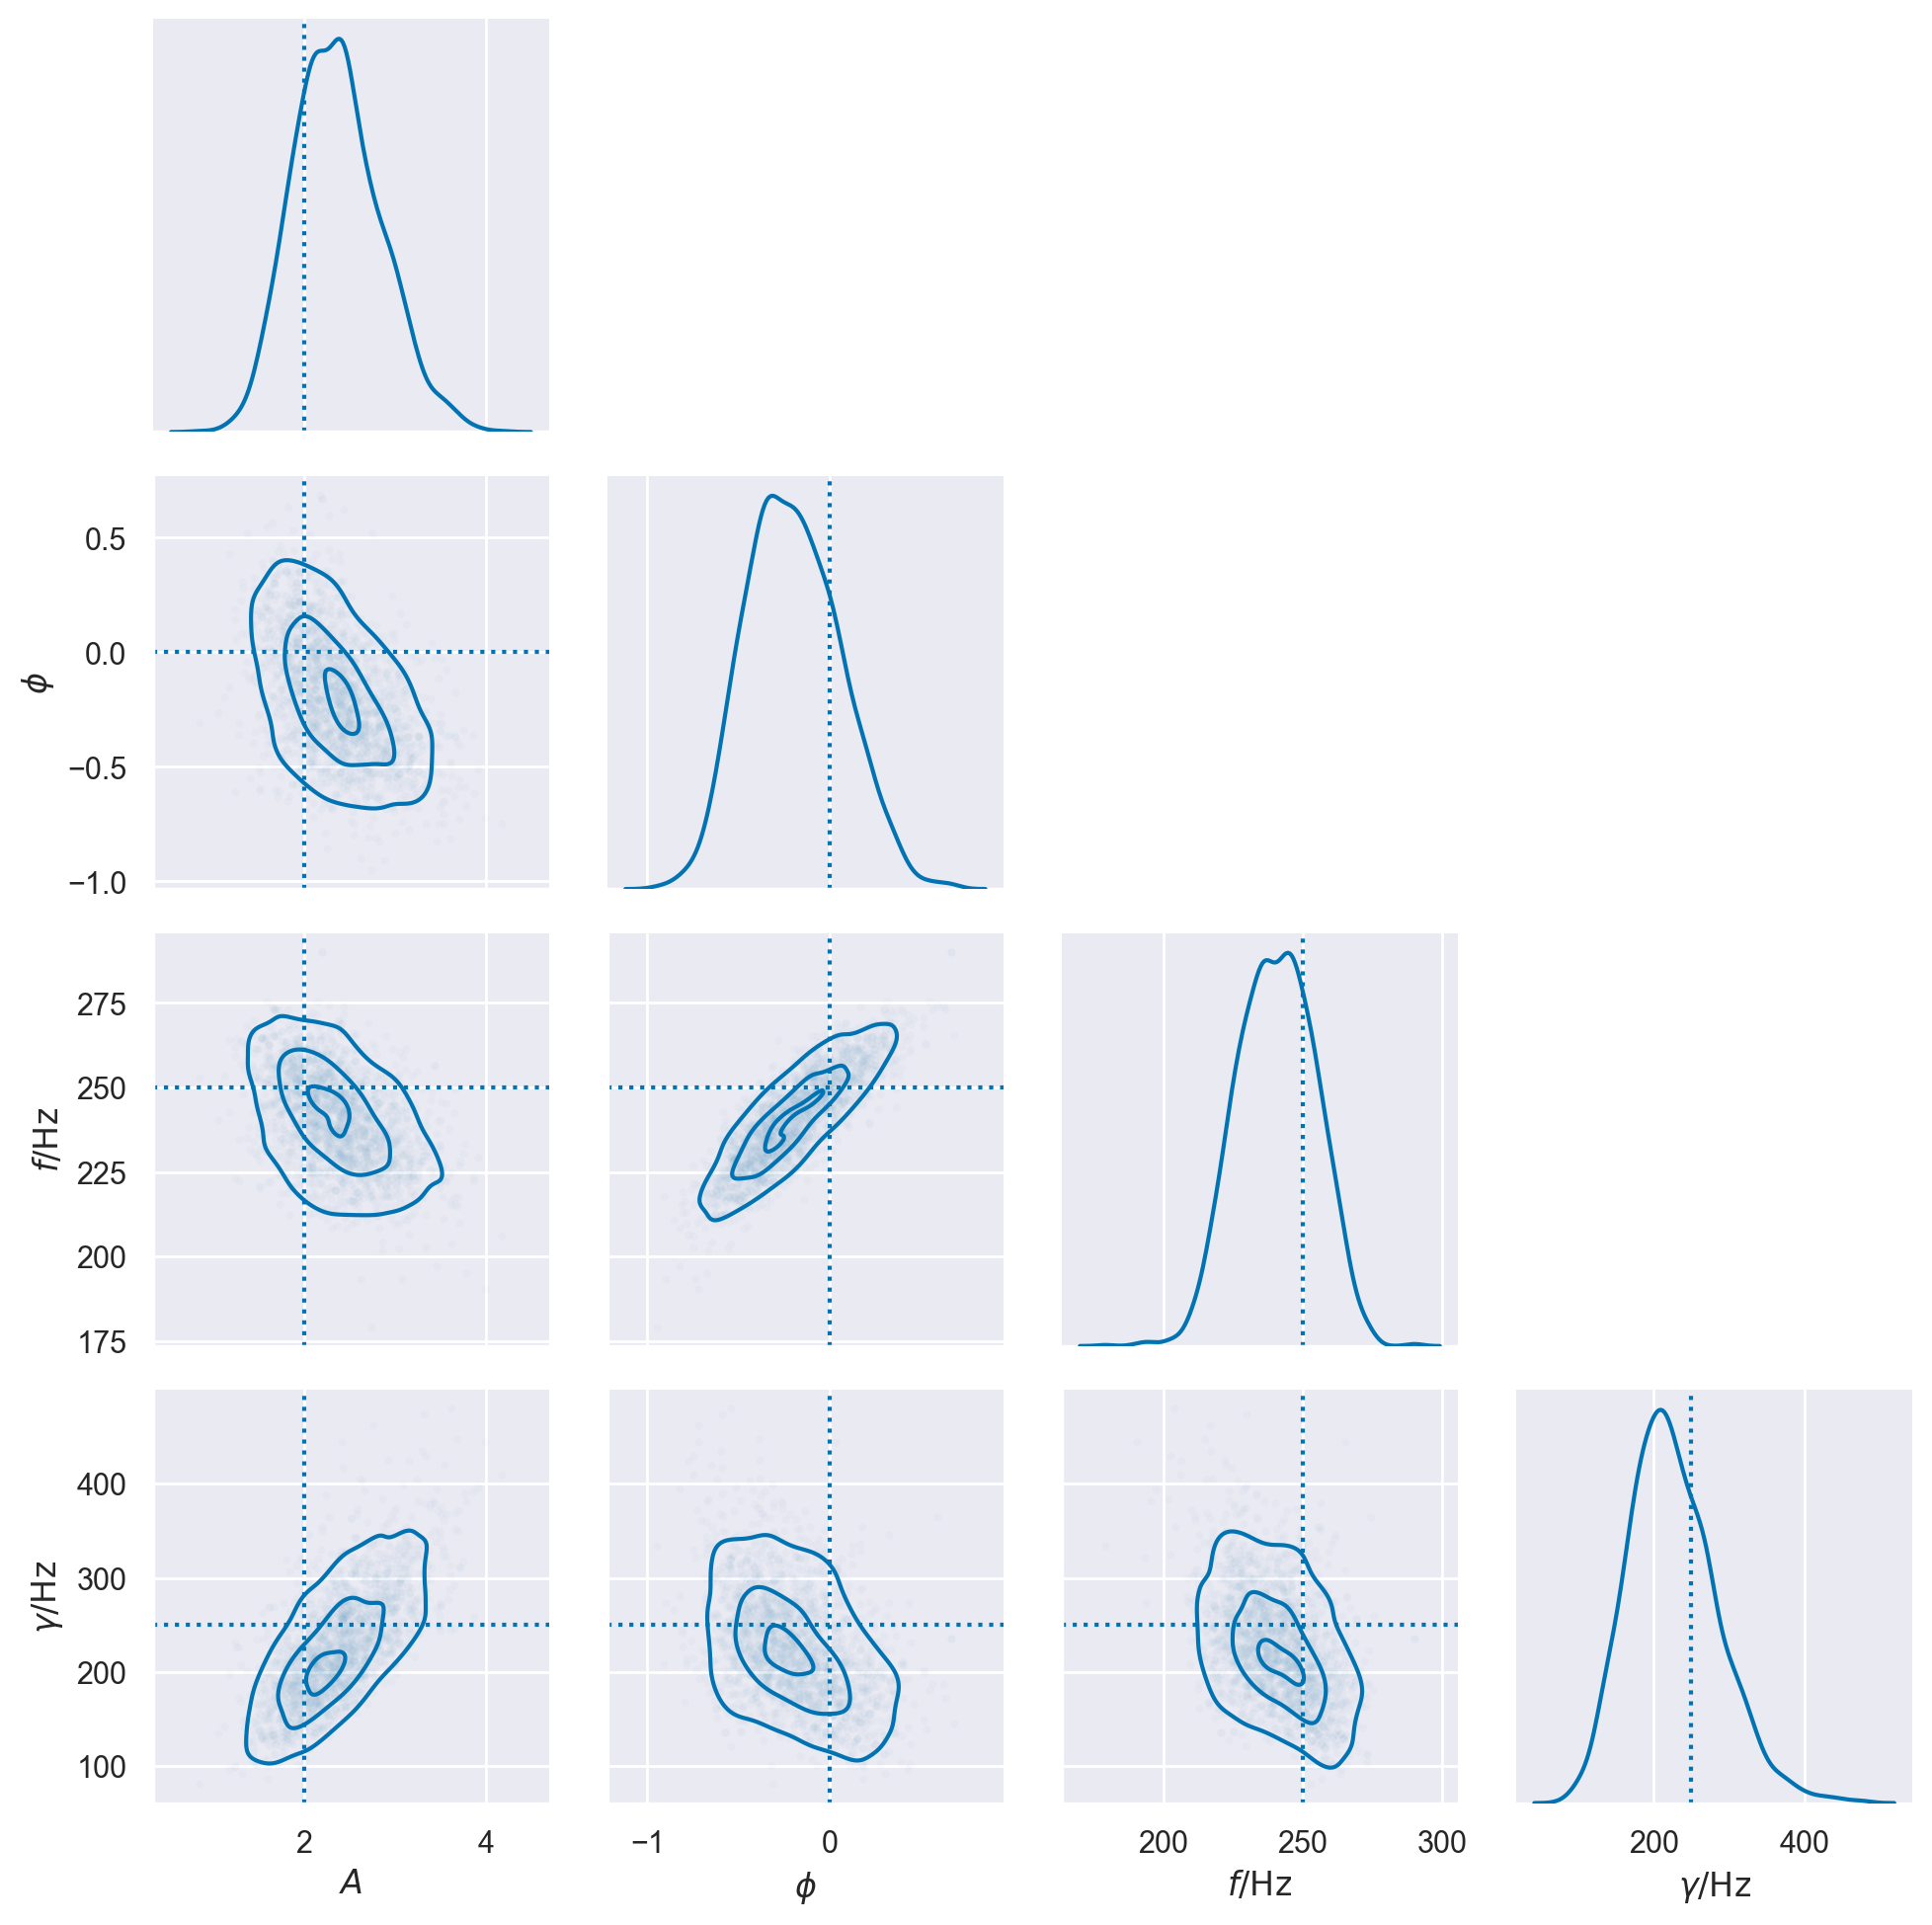

In [ ]:
df = pd.DataFrame({
    r'$A$': fit.result.posterior.A.values.flatten(),
    r'$\phi$': fit.result.posterior.phi.values.flatten(),
    r'$f / \mathrm{Hz}$': fit.result.posterior.f.values.flatten(),
    r'$\gamma  / \mathrm{Hz}$': fit.result.posterior.gamma.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False, corner=True)
pg.map_diag(sns.kdeplot);
pg.map_lower(sns.scatterplot, marker='.', alpha=0.02);
pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

# plot true values
for i, vi in enumerate(wf_kws.values()):
    for j, vj in enumerate(wf_kws.values()):
        if i >= j:
            pg.axes[i,j].axvline(vj, ls=':')
            if i != j:
                pg.axes[i,j].axhline(vi, ls=':')

### Reconstructions

Get mean signal reconstructions at each detector and plot them against the truth.

In [ ]:
# median reconstruction and 90%-credible envelope
wfs = [quantile(fit.result.posterior.h_det.values, q, axis=(0,1))[0,:]
       for q in [0.5, 0.95, 0.05]]
wfs = [rd.Data(wf, index=fit.result.constant_data.times[0,:]) for wf in wfs]

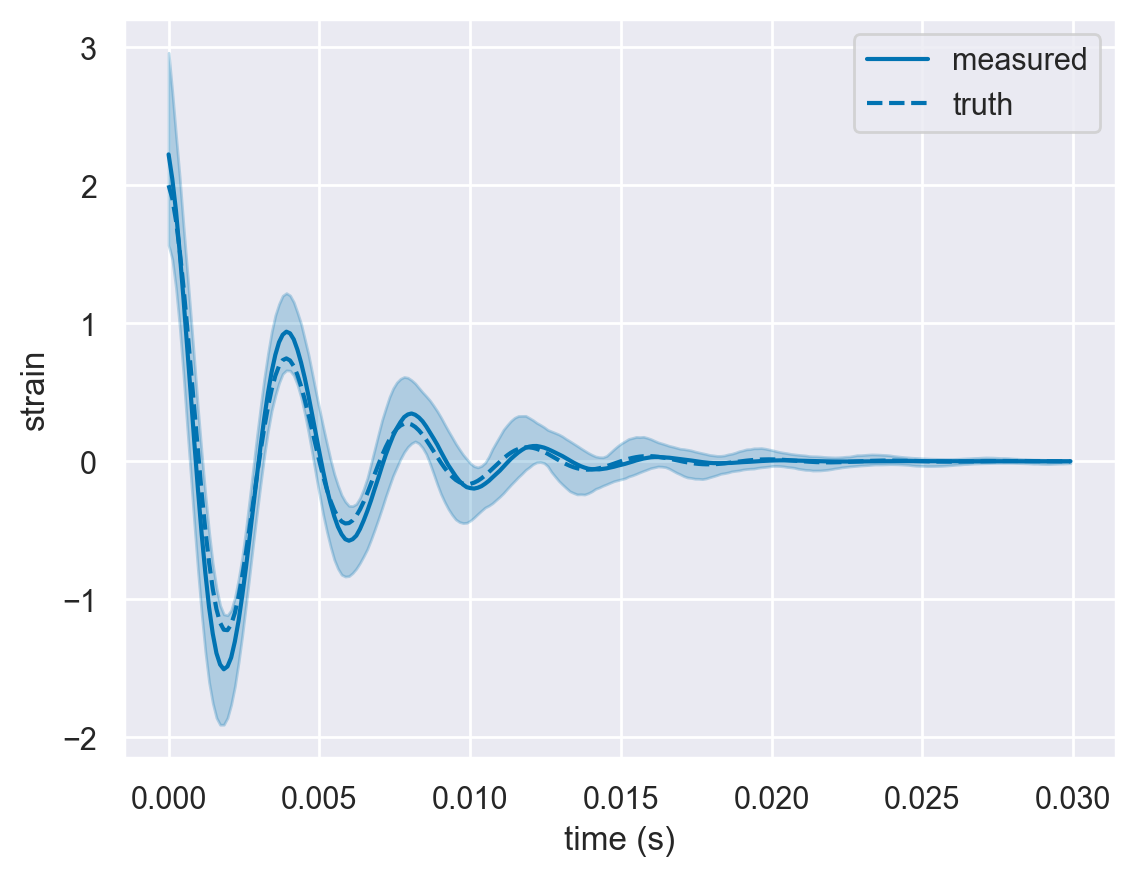

In [ ]:
# plot reconstructions computed above
m, u, d = wfs
l, = plot(m, label='measured')
fill_between(m.time, u, d, color=l.get_color(), alpha=0.25)

# plot truth (using time mask to select right times)
plot(signal[m.time], c=l.get_color(), ls='--', label='truth')
xlabel('time (s)')
ylabel('strain')
legend();

Let's compute the recovered  matched filter SNR, defined as $\rho = \left\langle h \mid d \right\rangle /  \left\langle h \mid h \right\rangle$. We can obtain a posterior on the recovered matched filter SNR by computing this quantity from random draws of the  posterior; the `Fit` object can do this automatically (and efficiently) for us.

In [ ]:
snrs_mf = fit.compute_posterior_snrs(optimal=False)

Also compute the injected matched-filter SNR for reference:

In [ ]:
injsnr_mf = dot(signal[m.time], data[m.time]) / linalg.norm(signal[m.time])

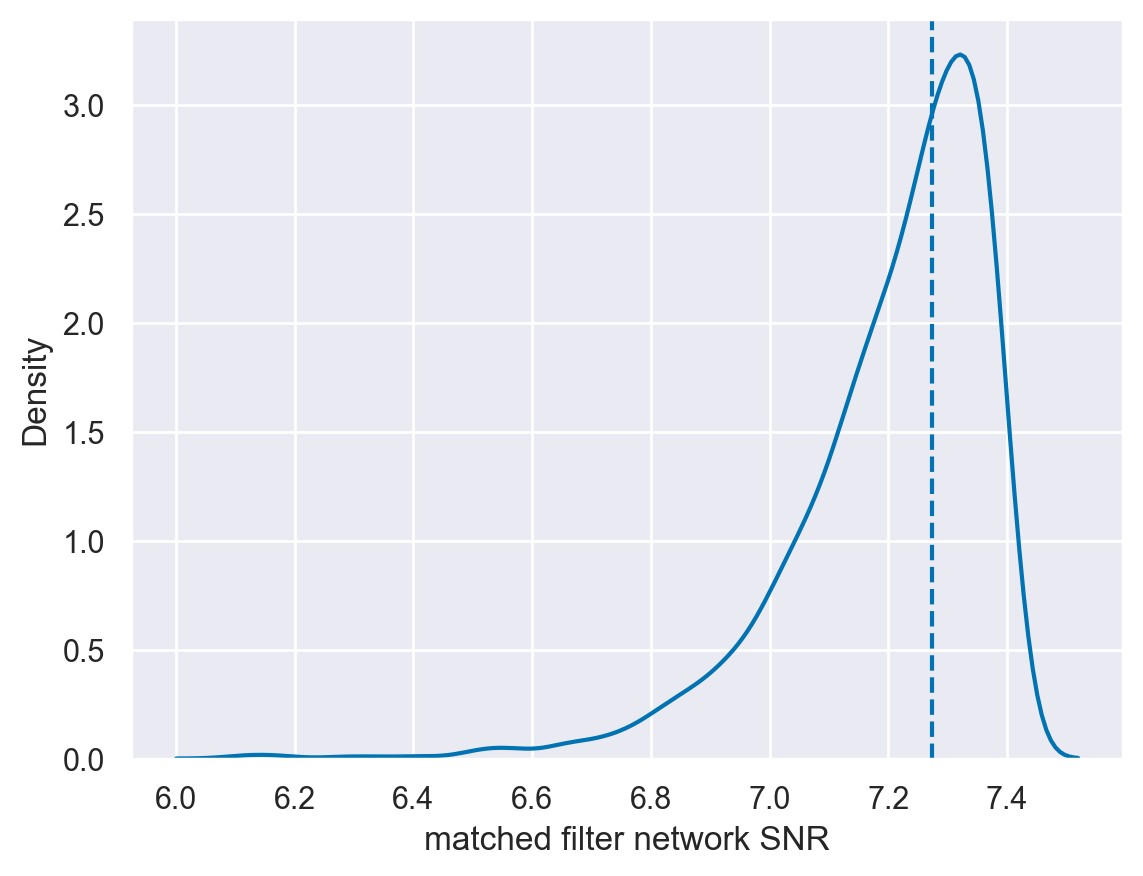

In [ ]:
sns.kdeplot(snrs_mf)
axvline(injsnr_mf, ls='--');
xlabel('matched filter network SNR');

### Saving

If you want, you can save the fit result to disk as follows:

In [ ]:
fit.result.to_netcdf('myfit.nc')

'myfit.nc'

And you can load that by doing:

In [ ]:
cached_result = az.from_netcdf('myfit.nc')

This new object, `cached_result`, will be the same as the original `fit.result`.